In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('project')
jovian.set_colab_id('1esUfI1EKGn7vkrWD8rpX_xHl1F2goNVR')

     |████████████████████████████████| 68 kB 5.3 MB/s 


In [ ]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
import torchvision
import time

In [ ]:
!gdown https://drive.google.com/uc?id=1Qc66kVqetwJIK7cKXnXxbPJy6gnpRSRI
!unzip The_Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
trainpath = '/content/seg_train/'
testpath = '/content/seg_test/'
predpath = '/content/seg_pred/'

In [ ]:
# defining all the train_set,test_set,pred_set
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms = tt.Compose([tt.Resize(img_size),
                              tt.Pad(8,padding_mode = 'reflect'),
                              tt.RandomCrop(img_size),
                              tt.ToTensor(),
                              tt.Normalize(*imagenet_stats)])
# as resnet 34 was trained on image_net normalised data we have to perform normalisation  on our data based on the 
# imagenet stats
test_tfms = tt.Compose([tt.Resize((img_size,img_size)),
                        tt.ToTensor(),
                        tt.Normalize(*imagenet_stats)])

train_set = ImageFolder(trainpath + 'seg_train/',transform = train_tfms)
test_set = ImageFolder(testpath + 'seg_test/',transform = test_tfms)
pred_set = ImageFolder(predpath,transform = test_tfms)

In [ ]:
len(train_set),len(test_set),len(pred_set)

(14034, 3000, 7301)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# as we normalised data,to view we have to denormalise it by multiplying with standard deviation and adding mean

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_set.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: buildings (0)


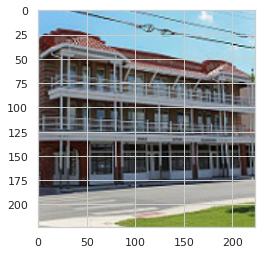

In [ ]:
show_image(*train_set[2])

In [ ]:
# Defining the batch_size and dataloaders for train_set,test_set,pred_set

batch_size = 64

train_dl = DataLoader(train_set,batch_size,shuffle = True,pin_memory = True)
test_dl = DataLoader(test_set,batch_size*2,pin_memory = True)
valid_dl = DataLoader(pred_set,batch_size,pin_memory = True)

In [ ]:
# defining a function show_batch to view the images loaded in a batch by a dataloader
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

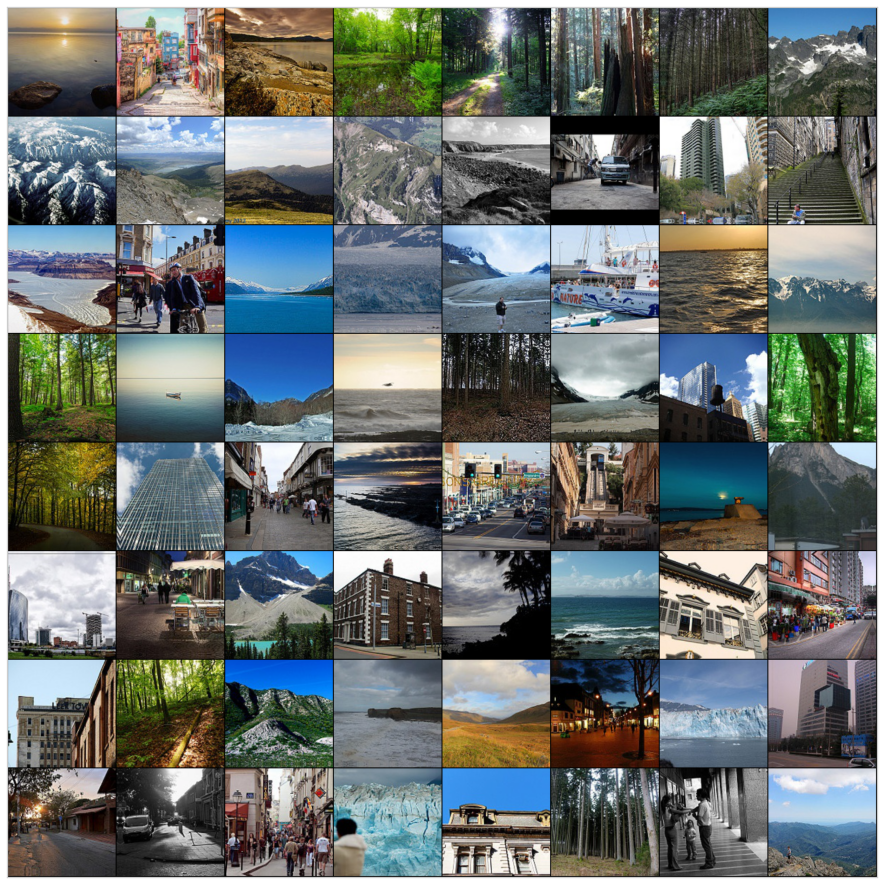

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# deifning function accuracy and imageclassificationbase class

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
from torchvision import models

# now here we use the transfer learning approach that is importing a model that was pretrained on millions of
# images using lot of computational power. here we just change the last fully connected layer called as classifier
# and retain the remaining layers and its parameters for initialisation.

# This method is so vastly used in the field of deep learning because, it reduces the computational power required
# and also the time required and increases the accuarcy
class transfer_model(ImageClassificationBase):
  def __init__(self,num_classes,pretrained = True):
    super().__init__()
    # using a pretrained model
    self.network = models.resnet34(pretrained=pretrained)
    #Replacing the last layer
    self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

  def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
val_dl = DeviceDataLoader(valid_dl,device)

In [ ]:
model = transfer_model(6)
model = to_device(model,device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

transfer_model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model,test_dl)]
history

[{'val_acc': 0.0860770046710968, 'val_loss': 2.0743212699890137}]

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.005

In [ ]:
%%time

history += fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.0524, val_loss: 1.0588, val_acc: 0.5980
Epoch [1], train_loss: 0.6880, val_loss: 1.0087, val_acc: 0.6838
Epoch [2], train_loss: 0.6012, val_loss: 0.9526, val_acc: 0.6861
Epoch [3], train_loss: 0.4996, val_loss: 0.4697, val_acc: 0.8326
Epoch [4], train_loss: 0.4821, val_loss: 0.5519, val_acc: 0.8026
Epoch [5], train_loss: 0.4336, val_loss: 0.5721, val_acc: 0.7962
Epoch [6], train_loss: 0.4054, val_loss: 1.1489, val_acc: 0.6421
Epoch [7], train_loss: 0.4172, val_loss: 0.4969, val_acc: 0.8191
Epoch [8], train_loss: 0.3808, val_loss: 1.1318, val_acc: 0.6569
Epoch [9], train_loss: 0.3311, val_loss: 0.3526, val_acc: 0.8752
CPU times: user 13min 35s, sys: 5min 31s, total: 19min 6s
Wall time: 19min 8s


In [ ]:
# as the valid accuracy was oscillating in last epocs executed we should reduce the learning rate and train
# to achieve optimal accuracy

epochs = 5
lr2 = 0.001
history += fit(epochs, lr2, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.2685, val_loss: 0.2972, val_acc: 0.8922
Epoch [1], train_loss: 0.2367, val_loss: 0.3156, val_acc: 0.8879
Epoch [2], train_loss: 0.2247, val_loss: 0.2925, val_acc: 0.8977
Epoch [3], train_loss: 0.2035, val_loss: 0.2994, val_acc: 0.8976
Epoch [4], train_loss: 0.1963, val_loss: 0.3249, val_acc: 0.8811


In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/me20b099/project


'https://jovian.ai/me20b099/project'